# Week 3 - Clustering with Spark MLlib

# Assignment: Recommending Actions from Clustering Analysis

In [2]:
import pandas as pd
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array

## Step 1: Attribute Selection

### Import Data
First let us read the contents of the file ad-clicks.csv. The following commands read in the CSV file in a table format and removes any extra whitespaces. So, if the CSV contained ' userid  ' it becomes 'userid'. 

In [3]:
adclicks_df = pd.read_csv('../data/flamingo-data/ad-clicks.csv')
adclicks_df = adclicks_df.rename(columns=lambda x: x.strip()) #remove whitespaces from headers

Let us display the first 5 lines of adclicks_df:

In [4]:
adclicks_df.head(5)

,timestamp,txId,userSessionId,teamId,userId,adId,adCategory
0,2016-05-26 15:13:22,5974,5809,27,611,2,electronics
1,2016-05-26 15:17:24,5976,5705,18,1874,21,movies
2,2016-05-26 15:22:52,5978,5791,53,2139,25,computers
3,2016-05-26 15:22:57,5973,5756,63,212,10,fashion
4,2016-05-26 15:22:58,5980,5920,9,1027,20,clothing


Next, We are going to add an extra column to the ad-clicks table and make it equal to 1. We do so to record the fact that each ROW is 1 ad-click. You will see how this will become useful when we sum up this column to find how many ads did a user click.

In [6]:
adclicks_df['adCount'] = 1

Let us display the first 5 lines of adclicks_df and see if a new column has been added:

In [7]:
adclicks_df.head(5)

,timestamp,txId,userSessionId,teamId,userId,adId,adCategory,adCount
0,2016-05-26 15:13:22,5974,5809,27,611,2,electronics,1
1,2016-05-26 15:17:24,5976,5705,18,1874,21,movies,1
2,2016-05-26 15:22:52,5978,5791,53,2139,25,computers,1
3,2016-05-26 15:22:57,5973,5756,63,212,10,fashion,1
4,2016-05-26 15:22:58,5980,5920,9,1027,20,clothing,1


Then let us read the contents of the file game-clicks.csv. The following commands read in the CSV file in a table format and removes any extra whitespaces. So, if the CSV contained ' userid ' it becomes 'userid'.

In [9]:
gameclicks_df = pd.read_csv('../data/flamingo-data/game-clicks.csv')
gameclicks_df = gameclicks_df.rename(columns=lambda x: x.strip()) #remove whitespaces from headers

Let us display the first 5 lines of gameclicks_df:

In [10]:
gameclicks_df.head(5)

,timestamp,clickId,userId,userSessionId,isHit,teamId,teamLevel
0,2016-05-26 15:06:55,105,1038,5916,0,25,1
1,2016-05-26 15:07:09,154,1099,5898,0,44,1
2,2016-05-26 15:07:14,229,899,5757,0,71,1
3,2016-05-26 15:07:14,322,2197,5854,0,99,1
4,2016-05-26 15:07:20,22,1362,5739,0,13,1


Next, We are going to add an extra column to the game-clicks table and make it equal to 1. We do so to record the fact that each ROW is 1 game-click. 
You will see how this will become useful when we sum up this column to find how many times did a user click.

In [11]:
gameclicks_df['clickCount'] = 1

Let us display the first 5 lines of gameclicks_df and see if a new column has been added:

In [12]:
gameclicks_df.head(5)

,timestamp,clickId,userId,userSessionId,isHit,teamId,teamLevel,clickCount
0,2016-05-26 15:06:55,105,1038,5916,0,25,1,1
1,2016-05-26 15:07:09,154,1099,5898,0,44,1,1
2,2016-05-26 15:07:14,229,899,5757,0,71,1,1
3,2016-05-26 15:07:14,322,2197,5854,0,99,1,1
4,2016-05-26 15:07:20,22,1362,5739,0,13,1,1


Next, let us read the contents of the file buy-clicks.csv. As before, the following commands read in the CSV file in a table format and removes any extra whitespaces. So, if the CSV contained ' userid  ' it becomes 'userid'.

In [13]:
buyclicks_df = pd.read_csv('../data/flamingo-data/buy-clicks.csv')
buyclicks_df = buyclicks_df.rename(columns=lambda x: x.strip()) #removes whitespaces from headers

Let us display the first 5 lines of buyclicks_df:

In [14]:
buyclicks_df.head(5)

,timestamp,txId,userSessionId,team,userId,buyId,price
0,2016-05-26 15:36:54,6004,5820,9,1300,2,3.0
1,2016-05-26 15:36:54,6005,5775,35,868,4,10.0
2,2016-05-26 15:36:54,6006,5679,97,819,5,20.0
3,2016-05-26 16:36:54,6067,5665,18,121,2,3.0
4,2016-05-26 17:06:54,6093,5709,11,2222,5,20.0


### Feature Selection

For this exercise, we can choose from buyclicks_df,  the 'price' of each app that a user purchases as an attribute that captures user's purchasing behavior. The following command selects 'userid' and 'price' and drops all other columns that we do not want to use at this stage.

In [15]:
user_purchases = buyclicks_df[['userId','price']] #select only userid and price
user_purchases.head(5)

,userId,price
0,1300,3.0
1,868,10.0
2,819,20.0
3,121,3.0
4,2222,20.0


From the adclicks_df, we will use the 'adCount' as an attribute that captures user's inclination to click on ads. The following command selects 'userId' and 'adCount' and drops all other columns that we do not want to use at this stage.

In [16]:
user_adclicks = adclicks_df[['userId','adCount']]

In [17]:
user_adclicks.head(5)

,userId,adCount
0,611,1
1,1874,1
2,2139,1
3,212,1
4,1027,1


Similarly, from the gameclicks_df,  we will use the 'clickCount' as an attribute that captures number of times of user's clicking on game. The following command selects 'userid' and 'clickCount' and drops all other columns that we do not want to use at this stage.

In [18]:
user_gameclicks = gameclicks_df[['userId','clickCount']]

In [19]:
user_gameclicks.head(5) #as we saw before, this line displays first five lines

,userId,clickCount
0,1038,1
1,1099,1
2,899,1
3,2197,1
4,1362,1


## Step 2: Training Data Set Creation

### Create the first aggregate feature for clustering

From each of these single ad-clicks per row, we can now generate total ad clicks per user. Let's pick a user with userid = 3. To find out how many ads this user has clicked overall, we have to find each row that contains userid = 3, and report the total number of such rows.

The following commands sum the total number of ads per user and rename the columns to be called 'userId' and 'totalAdClicks'. In the end, we want to get one row per user, if we are performing clustering over users.


In [21]:
ads_per_user = user_adclicks.groupby('userId').sum()
ads_per_user = ads_per_user.reset_index()
ads_per_user.columns = ['userId', 'totalAdClicks'] #rename the columns

Let us display the first 5 lines of 'ads_per_user' to see if there is a column named 'totalAdClicks' containing total adclicks per user.

In [22]:
ads_per_user.head(5)

,userId,totalAdClicks
0,1,44
1,8,10
2,9,37
3,10,19
4,12,46


### Create the second aggregate feature for clustering

The following commands sum the total number of clicking on game per user and rename the columns to be called 'userId' and 'totalGameClicks'. In the end, we want to get one row per user, if we are performing clustering over users.

In [23]:
game_clicks_per_user = user_gameclicks.groupby('userId').sum()
game_clicks_per_user = game_clicks_per_user.reset_index()
game_clicks_per_user.columns = ['userId', 'totalGameClicks'] #rename the columns

Let us display the first 5 lines of 'game_clicks_per_user' to see if there is a column named 'totalGameClicks' containing total gameclicks per user.

In [24]:
game_clicks_per_user.head(5)

,userId,totalGameClicks
0,0,1355
1,1,716
2,2,231
3,6,151
4,8,380


### Create the third aggregate feature for clustering

Similar to what we did for adclicks and gameclicks, here we find out how much money in total did each user spend on buying in-app purchases. As an example, let's pick a user with userId = 9. To find out the total money spent by this user, we have to find each row that contains userId = 9, and report the sum of the column'price' of each product they purchased.

The following commands sum the total money spent by each user and rename the columns to be called 'userId' and 'revenue'.

In [25]:
revenue_per_user = user_purchases.groupby('userId').sum()
revenue_per_user = revenue_per_user.reset_index()
revenue_per_user.columns = ['userId', 'revenue'] #rename the columns

In [26]:
revenue_per_user.head(5)

,userId,revenue
0,1,21.0
1,8,53.0
2,9,80.0
3,10,11.0
4,12,215.0


### Merge the three tables

Let's see what we have so far. We have a table called revenue_per_user, where each row contains total money a user (with that 'userId') has spent. We have a table called ads_per_user where each row contains total number of ads a user has clicked. We also have another table called game_clicks_per_user where each row contains total number of clicking of a user in the game. We will use revenue_per_user, ads_per_user and game_clicks_per_user as features / attributes to capture our users' behavior.

Let us combine these three attributes (features) so that each row contains both attributes per user. Let's merge these three tables to get one single table we can use for K-Means clustering.

In [28]:
combined_df = ads_per_user.merge(game_clicks_per_user, on='userId') #userId, adCount, clickCount
combined_df = combined_df.merge(revenue_per_user, on='userId') #userId, adCount, clickCount, price

In [29]:
combined_df.head(5) #display how the merged table looks

,userId,totalAdClicks,totalGameClicks,revenue
0,1,44,716,21.0
1,8,10,380,53.0
2,9,37,508,80.0
3,10,19,3107,11.0
4,12,46,704,215.0


### Create the final training dataset

Our training data set is almost ready. At this stage we can remove the 'userId' from each row, since 'userId' is a computer generated random number assigned to each user. It does not capture any behavioral aspect of a user. One way to drop the 'userId', is to select the other two columns.

In [30]:
cluster_df = combined_df[['totalAdClicks', 'totalGameClicks','revenue']]
cluster_df.head(5)

,totalAdClicks,totalGameClicks,revenue
0,44,716,21.0
1,10,380,53.0
2,37,508,80.0
3,19,3107,11.0
4,46,704,215.0


### Display the dimensions of the training dataset

Display the dimension of the training data set. To display the dimensions of the training_df, simply add `.shape` as a suffix and hit enter.

In [31]:
cluster_df.shape

(543, 3)

The following two commands convert the tables we created into a format that can be understood by the `KMeans.train` function.

line[0] refers to the first column. line[1] refers to the second column. If you have more than 2 columns in your training table, modify this command by adding line[2], line[3], line[4] ...

In [33]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
print('Spark',pyspark.__version__)
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

Spark 2.3.1


In [38]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)
p_df = sqlContext.createDataFrame(cluster_df)
parsed_data = p_df.rdd.map(lambda line: array([line[0], line[1], line[2]])) #totalAdClicks, totalGameClicks, revenue

## Step 3: Train to Create Cluster Centers

### Train KMeans model

In [125]:
km_model = KMeans.train(parsed_data, 3, maxIterations=10, initializationMode="random")

In [126]:
headers = cluster_df.columns.values.tolist()
centers = [a.tolist() for a in km_model.centers]

### Display the centers of three clusters formed

In [130]:
df = pd.DataFrame(centers, columns=headers)
df.head()

,totalAdClicks,totalGameClicks,revenue
0,36.441341,926.117318,46.966480
1,32.355556,2310.644444,39.422222
2,24.987461,357.959248,35.065831


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023526A40E48>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000023526C45A20>], dtype=object)

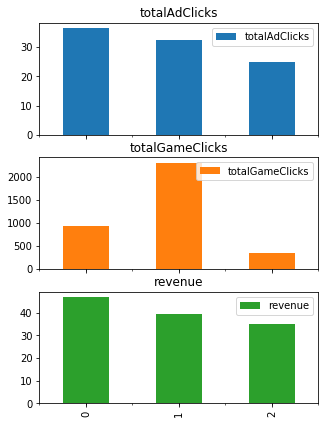

In [128]:
%matplotlib inline
df.plot(kind='bar',subplots=True, figsize=(5,7), use_index=True)